# Estimation on real data using MSM

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from Model import RetirementClass
import figs
import SimulatedMinimumDistance as SMD

# Global modules
import numpy as np
import matplotlib.pyplot as plt

# Singles - Calibration to data in Jørgensen 2014

In [2]:
shape = (2,11)
moments = pd.read_excel('SASdata/Thomas/single_moments.xlsx')
mom_data = moments['Mom_data'].to_numpy()
mom_pred = moments['Mom_est'].to_numpy()
weight = np.eye(mom_data.size) # identity matrix

### Set up estimation

In [3]:
Single = RetirementClass(Thomas=True, simN=int(1e5), simT=68-57+1, alpha_1=0.053)
Single.solve()
Single.simulate()

In [4]:
# function to generate moments
def mom_fun(Single):
    return SMD.MomFunSingleThomas(Single)

In [5]:
add_str = '_est'
#est_par = ("alpha_0_male", "alpha_0_female", "alpha_1", "sigma_eta")
est_par = ("alpha_0_male", "alpha_0_female", "sigma_eta")
# Setup estimation
smd = SMD.SimulatedMinimumDistance(Single,mom_data,mom_fun)
smd.est_par = est_par

### Estimate

In [6]:
#theta0 = SMD.start(3,bounds=[(0.0,1.0), (0.0,1.0), (-1.0,1.0), (0.1,1.0)])
theta0 = SMD.start(5,bounds=[(0.0,1.0), (0.0,1.0), (0.1,1.0)])

In [7]:
smd.MultiStart(theta0,weight)
theta = smd.est

1 estimation:
success: True | feval: 114 | time: 1.4 min | obj: 0.024465566222198573
start par: [0.132, 0.474, 0.792]
par:       [0.41968581 0.40711271 0.93446684]

2 estimation:
success: True | feval: 92 | time: 1.1 min | obj: 0.024467491228255273
start par: [0.513, 0.453, 0.593]
par:       [0.42693205 0.41091811 0.9535091 ]

3 estimation:
success: True | feval: 69 | time: 0.9 min | obj: 0.02450961524688511
start par: [0.849, 0.472, 0.613]
par:       [0.41756844 0.40015039 0.90720596]

4 estimation:
success: True | feval: 128 | time: 1.6 min | obj: 0.024467370826712978
start par: [0.539, 0.819, 0.486]
par:       [0.42384402 0.4115179  0.95921469]

5 estimation:
success: True | feval: 97 | time: 1.2 min | obj: 0.02446256204594167
start par: [0.544, 0.882, 0.766]
par:       [0.42870633 0.40800656 0.94883432]

final estimation:
success: True | feval: 81 | obj: 0.024348140784736752
total estimation time: 0.2 hours
start par: [0.42870633 0.40800656 0.94883432]
par: [0.4233398  0.41019969 0

In [11]:
Nobs = 27412 # equal to number of men-households (which is lower than women)
smd.std_error(theta,weight,Nobs=Nobs,Nsim=(5e5/2)/Nobs) # Nsim was set to 5e5 in MultiStart 
std_error = smd.std
smd.obj_fun(theta,weight) # set theta as parameters
print('Parameters:', np.round(theta,3))
print('Std error :', np.round(std_error,4))
if not "alpha_1" in est_par: # also save alpha_1
    est_par = list(est_par)
    est_par.append("alpha_1")
    theta = list(theta)
    theta.append(Single.par.alpha_1)
SMD.save_est(est_par,theta,name='SingleThomas') # save parameters

Parameters: [0.423 0.41  0.958]
Std error : [0.0002 0.0001 0.0003]


### Model fit

In [14]:
def model_fit(ma,Single,mom_data,mom_pred,shape):
    mom_data = {'y': [mom_data.reshape(shape)[ma]], 'x': np.arange(58,69), 'label': ['Data'], 'color': 'k',
                'linestyle': ['None'], 'marker': 'o'}
    mom_pred = {'y': [mom_pred.reshape(shape)[ma]], 'x': np.arange(58,69), 'label': ['Jørgensen2014'], 'color': 'b',
                'linestyle': ['--']}    
    pred = figs.retirement_probs(Single,MA=[ma])
    pred['legendsize'] = 15
    return [mom_data, mom_pred, pred]

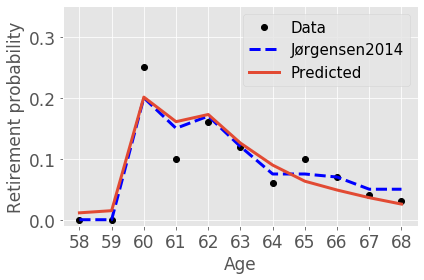

In [15]:
figs.MyPlot(model_fit(0,Single,mom_data,mom_pred,shape),
            ylim=[-0.01,0.35],linewidth=3).savefig('figs/ModelFit/ThomasSingleWomen.png')

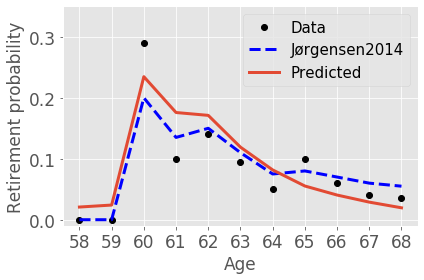

In [16]:
figs.MyPlot(model_fit(1,Single,mom_data,mom_pred,shape),
            ylim=[-0.01,0.35],linewidth=3).savefig('figs/ModelFit/ThomasSingleMen.png')

# Singles - Estimate on own data

In [53]:
shape = (11,8)
moments = pd.read_excel('SASdata/single_moments.xlsx')
mom_data = moments['Moments'].to_numpy()
mm = mom_data.reshape(shape)
mom_se = moments['SE'].to_numpy()
weight = SMD.weight_matrix_single(mom_se,shape,factor=[1/10,1/10,1,1,1,1,1,1,1,1,1])
ww = np.diag(weight).reshape(shape)

### Weight matrix

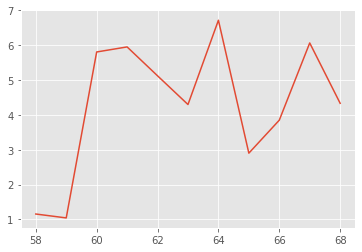

In [54]:
plt.plot(np.arange(58,69),np.mean(ww,axis=1))

### Moments

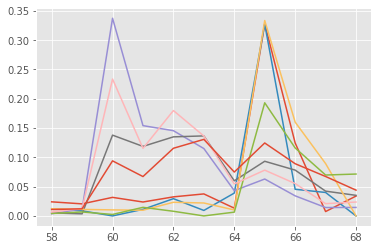

In [55]:
plt.plot(np.arange(58,69),mm)
plt.show()

### Set up estimation

In [56]:
Single = RetirementClass(simN=int(1e5), simT=68-57+1)
Single.solve()
Single.simulate()

In [64]:
# function to generate moments
def mom_fun(Single):
    return SMD.MomFunSingle(Single)

In [65]:
add_str = '_est'
est_par = ("alpha_0_male", "alpha_0_female", "alpha_1", "sigma_eta")
est_par_tex = (r'$\alpha_0^m$', r'$\alpha_0^f$', r'$\alpha_1$', r'$\sigma$')
fixed_par = ('R', 'rho', 'beta', 'gamma', 
             'priv_pension_male', 'priv_pension_female', 'g_adjust', 'pi_adjust_m', 'pi_adjust_f')
fixed_par_tex = (r'$R$', r'$\rho$', r'$\beta$', r'$\gamma$', 
                 r'$PPW^m$', r'$PPW^f$', r'$g$', r'$\pi_m$', r'$\pi_f$')

# Setup estimation
smd = SMD.SimulatedMinimumDistance(Single,mom_data,mom_fun)
smd.est_par = est_par

### Estimate

In [66]:
theta0 = SMD.start(10,bounds=[(0.0,1.0), (0.0,1.0), (-1.0,1.0), (0.1,0.8)])

In [67]:
smd.MultiStart(theta0,weight)
theta = smd.est

1 estimation:
success: True | feval: 135 | time: 2.2 min | obj: 0.8863588348103106
start par: [0.179, 0.91, -0.772, 0.427]
par:       [ 0.36456728  0.6131922  -0.1804749   0.83470543]

2 estimation:
success: True | feval: 108 | time: 1.6 min | obj: 0.834254832445058
start par: [0.573, 0.318, -0.057, 0.406]
par:       [ 0.27372597  0.52716836 -0.04544247  0.5017441 ]

3 estimation:
success: True | feval: 329 | time: 4.9 min | obj: 1.0886314036678875
start par: [0.894, 0.585, 0.992, 0.265]
par:       [ 0.51582632  0.53661645 -0.18470545  0.78459999]

4 estimation:
success: True | feval: 182 | time: 2.6 min | obj: 0.8398757430413785
start par: [0.536, 0.469, -0.763, 0.228]
par:       [ 0.31204511  0.54779212 -0.081091    0.6727234 ]

5 estimation:
success: True | feval: 216 | time: 3.3 min | obj: 1.0953048721202663
start par: [0.017, 0.285, 0.575, 0.211]
par:       [-0.03714129  0.44359576  0.04648055  1.48489542]

6 estimation:
success: True | feval: 110 | time: 1.6 min | obj: 0.88087801

In [68]:
Nobs = 500
smd.std_error(theta,weight,Nobs=Nobs,Nsim=Single.par.simN/Nobs)
std_error = smd.std
smd.obj_fun(theta,weight) # set theta as parameters
print('Parameters:', np.round(theta,3))
print('Std error :', np.round(std_error,4))
SMD.save_est(est_par,theta,name='Single') # save parameters

Parameters: [ 0.263  0.506 -0.045  0.565]
Std error : [0.0019 0.0019 0.0039 0.0009]


### Model fit

In [ ]:
def model_fit():
    pass

In [101]:
def mom_data_total(MA):
    data = pd.read_excel('SASdata/single_moments_total.xlsx')
    mom = np.reshape(data['Moments'].to_numpy(), newshape=(int(len(data)/3),3), order='F')
    if len(MA)>1:
        return mom[:,-1]
    else:
        return mom[:,MA[0]]
    
def model_fit(MA):
    G_data = {'y': [mom_data_total(MA=MA)], 'x': np.arange(58,69), 'label': ['Data'], 'color': 'k', 
              'linestyle': ['None'], 'marker': 'o'}
    G_pred = figs.retirement_probs(Single,MA=MA)
    return [G_data,G_pred]

Women

In [38]:
figs.MyPlot(model_fit([0]),ylim=[-0.01,0.4],linewidth=3,save=True).savefig('figs/ModelFit/SingleWomen.png')

Men

In [39]:
figs.MyPlot(model_fit([1]),ylim=[-0.01,0.4],linewidth=3,save=True).savefig('figs/ModelFit/SingleMen.png')

### Sensitivity to first step calibrated parameters

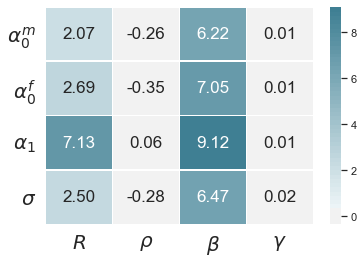

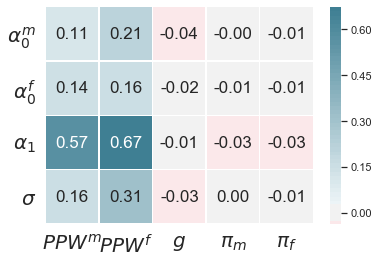

In [230]:
smd.recompute=True
smd.sensitivity(theta,weight,fixed_par)
figs.sens_fig_tab(smd.sens2[:,:4],smd.sens2e[:,:4],theta,est_par_tex,fixed_par_tex[:4]).savefig('figs/Sens/SinglePref.png')
figs.sens_fig_tab(smd.sens2[:,4:],smd.sens2e[:,4:],theta,est_par_tex,fixed_par_tex[4:]).savefig('figs/Sens/SingleCali.png')

### Clean up (to save memory)

In [ ]:
del Single

# Couples - calibrate to data in Jørgensen 2014

In [2]:
shape = (2,11)
moments = pd.read_excel('SASdata/Thomas/couple_moments.xlsx')
mom_data = moments['Mom_data'].to_numpy()
mom_pred = moments['Mom_est'].to_numpy()
weight = np.eye(mom_data.size) # identity matrix

### Set up estimation

In [ ]:
Couple = RetirementClass(couple=True, Thomas=True, simN=int(1e5), simT=68-53+1)#, cov=0)
Couple.solve()
Couple.simulate()

In [ ]:
# function to generate moments
def mom_fun(Couple):
    return SMD.MomFunCoupleThomas(Couple)

In [ ]:
# est_par = ("alpha_0_male", "alpha_0_female", "alpha_1", "sigma_eta")
est_par = ("alpha_0_male", "alpha_0_female", "sigma_eta")

# Setup estimation and set phi equal to the ones reported in Jørgensen2014
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun)
smd.est_par = est_par

### Estimate

In [ ]:
Couple.par.alpha_1 = 0.053
Couple.Single.par.alpha_1 = 0.053

In [ ]:
# theta0 = SMD.start(1,bounds=[(0.0,1.0), (0.0,1.0), (-1.0,1.0), (0.1,0.8)])
theta0 = SMD.start(5,bounds=[(0.0,1.0), (0.0,1.0), (0.1,1.0)])

In [ ]:
#smd.print_iter = [True,20]
smd.MultiStart(theta0,weight)
theta = smd.est

1 estimation:
success: True | feval: 77 | time: 32.7 min | obj: 0.02430240035760383
start par: [0.888, 0.177, 0.982]
par:       [0.2722796  0.23979047 0.51232743]

2 estimation:
success: True | feval: 116 | time: 47.6 min | obj: 0.02386153525335511
start par: [0.884, 0.551, 0.835]
par:       [0.37168798 0.15074072 0.49629651]



In [ ]:
Nobs = 73844 # equal to number of men-households (which is lower than women)
smd.std_error(theta,weight,Nobs=Nobs,Nsim=5e5/Nobs) # Nsim was set to 5e5 in MultiStart 
std_error = smd.std
smd.obj_fun(theta,weight) # set theta as parameters
print('Parameters:', np.round(theta,3))
print('Std error :', np.round(std_error,4))
if not "alpha_1" in est_par: # also save alpha_1
    est_par = list(est_par)
    est_par.append("alpha_1")
    theta = list(theta)
    theta.append(Single.par.alpha_1)
SMD.save_est(est_par,theta,name='CoupleThomas') # save parameters

### Model fit

In [ ]:
def model_fit(ma,Couple,mom_data,mom_pred,shape):
    mom_data = {'y': [mom_data.reshape(shape)[ma]], 'x': np.arange(58,69), 'label': ['Data'], 'color': 'k',
                'linestyle': ['None'], 'marker': 'o'}
    mom_pred = {'y': [mom_pred.reshape(shape)[ma]], 'x': np.arange(58,69), 'label': ['Jørgensen2014'], 'color': 'b',
                'linestyle': ['--']}    
    pred = figs.retirement_probs_c(Couple,ma=ma)
    pred['legendsize'] = 15
    return [mom_data, mom_pred, pred]

In [ ]:
figs.MyPlot(model_fit(0,Couple,mom_data,mom_pred,shape),
            ylim=[-0.01,0.35],linewidth=3).savefig('figs/ModelFit/ThomasCoupleWomen.png')

In [ ]:
figs.MyPlot(model_fit(1,Couple,mom_data,mom_pred,shape),
            ylim=[-0.01,0.35],linewidth=3).savefig('figs/ModelFit/ThomasCoupleMen.png')

### Now re-estimate with phi=0

In [ ]:
Couple.par.alpha_1 = 0.053
Couple.Single.par.alpha_1 = 0.053
Couple.par.phi_0_male = 0.0
Couple.par.phi_0_female = 0.0
Couple.par.phi_1 = 0.0

In [ ]:
est_par = ("alpha_0_male", "alpha_0_female", "sigma_eta")
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun)
smd.est_par = est_par
theta0 = SMD.start(5,bounds=[(0.0,1.0), (0.0,1.0), (0.1,1.0)])

In [ ]:
#smd.print_iter = [True,20]
smd.MultiStart(theta0,weight)
theta = smd.est

In [ ]:
Nobs = 73844 # equal to number of men-households (which is lower than women)
smd.std_error(theta,weight,Nobs=Nobs,Nsim=5e5/Nobs) # Nsim was set to 5e5 in MultiStart 
std_error = smd.std
smd.obj_fun(theta,weight) # set theta as parameters
print('Parameters:', np.round(theta,3))
print('Std error :', np.round(std_error,4))
if not "alpha_1" in est_par: # also save alpha_1
    est_par = list(est_par)
    est_par.append("alpha_1")
    theta = list(theta)
    theta.append(Single.par.alpha_1)
SMD.save_est(est_par,theta,name='RestCoupleThomas') # save parameters

In [ ]:
figs.MyPlot(model_fit(0,Couple,mom_data,mom_pred,shape),
            ylim=[-0.01,0.35],linewidth=3).savefig('figs/ModelFit/ThomasRestCoupleWomen.png')

In [ ]:
figs.MyPlot(model_fit(1,Couple,mom_data,mom_pred,shape),
            ylim=[-0.01,0.35],linewidth=3).savefig('figs/ModelFit/ThomasRestCoupleMen.png')

# Couples - Estimate on own data

In [122]:
shape(2,11,9+16)
moments = pd.read_excel('SASdata/couple_moments.xlsx',skip_blank_lines=False)
mom_data = np.concatenate((moments['Moments_H'].to_numpy(),moments['Moments_W'].to_numpy()))
mm = mom_data.reshape(shape)
mom_data[np.isnan(mom_data)] = 0
mom_se = np.concatenate((moments['SE_H'].to_numpy(),moments['SE_W'].to_numpy()))
weight = SMD.weight_matrix_couple(mom_se,shape,factor=[1/5,1/5,1,1,1,1,1,1,1,1,1]) # factor rescales the time periods
ww = np.diag(weight).reshape(shape)

### Weight matrix

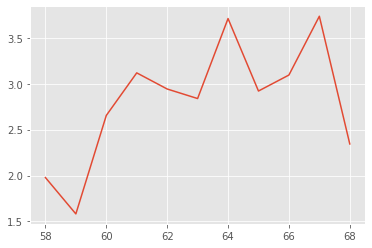

In [123]:
plt.plot(np.arange(58,69),np.mean(ww,axis=(0,2)))

### Moments - Women

In [40]:
plt.plot(np.arange(58,69), mm[1,:,:9])
plt.show()

In [41]:
plt.plot(np.arange(58,69), mm[1,:,9:])
plt.show()

Moments - Men

In [42]:
plt.plot(np.arange(58,69), mm[0,:,:9])
plt.show()

In [43]:
plt.plot(np.arange(58,69), mm[0,:,9:])
plt.show()

### Set up estimation

In [9]:
Couple = RetirementClass(couple=True, simN=int(1e5), simT=68-53+1, cov=0)
Couple.solve()
Couple.simulate()

In [10]:
# function to generate moments
def mom_fun(sim):
    return SMD.MomFunCouple(Couple)

In [11]:
add_str = '_est'
est_par = ("alpha_0_male", "alpha_0_female", "alpha_1", "sigma_eta", "phi_0_male", "phi_1")
est_par_tex = (r'$\alpha_0^m$', r'$\alpha_0^f$', r'$\alpha_1$', r'$\sigma$', r'$\phi_0$', r'$\phi_1$')
fixed_par = ('R', 'rho', 'beta', 'gamma', 'v',
             'priv_pension_male', 'priv_pension_female', 'g_adjust', 'pi_adjust_m', 'pi_adjust_f')
fixed_par_tex = (r'$R$', r'$\rho$', r'$\beta$', r'$\gamma$', r'$v$', 
                 r'$PPW^m$', r'$PPW^f$', r'$g$', r'$\pi_m$', r'$\pi_f$')

# Setup estimation
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun)
smd.est_par = est_par

### Estimate

In [12]:
theta0 = SMD.start(10,bounds=[(0.0,1.0),(0.0,1.0),(0.2,0.8),(-1.0,1.0),(0.5,2.0),(-1.0,1.0)])

In [44]:
smd.print_iter = [True,100] # print every 100 function eval
smd.MultiStart(theta0,weight)
theta = smd.est

In [ ]:
Nobs = 500
smd.std_error(theta,weight,Nobs=Nobs,Nsim=Couple.par.simN/Nobs)
std_error = smd.std
print('Parameters:', np.round(theta,3))
print('Std error :', np.round(std_error,4))
SMD.save_est(est_par,theta,name='Couple',couple=True) # save parameters

### Estimate (phi=0)

In [223]:
Couple.par.phi_0_male = 0
Couple.par.phi_0_female = 0
Couple.par.phi_1 = 0
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun)
smd.est_par = est_par[0:4]

In [243]:
theta0 = SMD.start(10,bounds=[(0.0,1.0),(0.0,1.0),(-1.0,1.0),(0.2,0.8)])

In [242]:
smd.print_iter = [True,100] # print every 100 function eval
smd.MultiStart(theta0,weight)
theta = smd.est

In [61]:
Nobs = 500
smd.std_error(theta,weight,Nobs=Nobs,Nsim=Couple.par.simN/Nobs)
std_error = smd.std
print('Parameters:', np.round(theta,3))
print('Std error :', np.round(std_error,4))
SMD.save_est(est_par,theta,name='RestCouple',couple=True) # save parameters

Parameters: [ 1.075  0.088  0.064  1.025  0.315  0.678 -0.408]
Std error : [0.0002 0.0002 0.003  0.0012 0.0001 0.0021 0.0009]


# Wait with this

### Model fit

In [253]:
theta = list(SMD.load_est(name='Couple',couple=True)[0].values())
smd.obj_fun(theta,weight) # set theta as parameters

[0.4, 0.4, 0.053, 0.435, 1.187, 1.671, -0.621]

In [211]:
def model_fit_ad(ma,ad):
    moments = pd.read_excel('SASdata/couple_moments.xlsx',skip_blank_lines=False)
    mom_data = np.concatenate((moments['Moments_H'].to_numpy(),moments['Moments_W'].to_numpy())).reshape(2,11,25)
    G_data = {'y': [mom_data[-ma+1,:,ad+4]], 'x': np.arange(58,69), 'label': ['Data (ad='+str(ad)+')'], 'color': 'k',
              'linestyle': ['None'], 'marker': 'o'}
    G_pred = figs.retirement_probs_c(Couple,ma,AD=[ad])
    if ma == 1:
        G_pred['ylabel'] = None
    return [G_data,G_pred]

Women

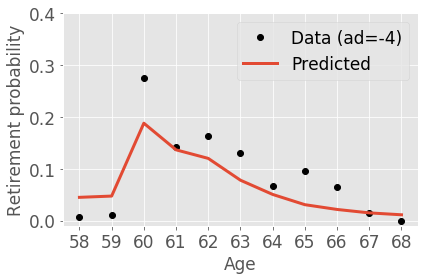

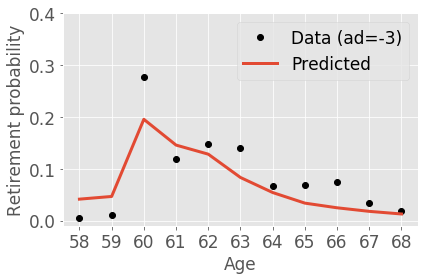

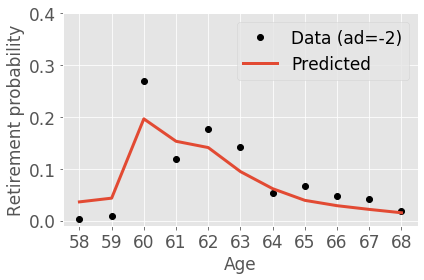

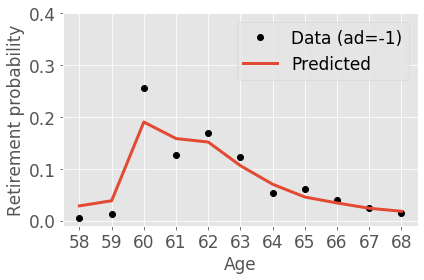

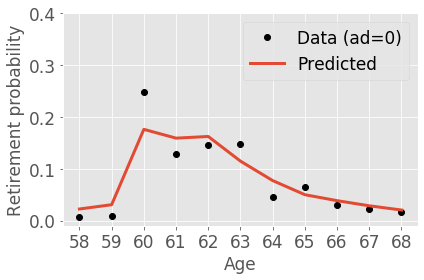

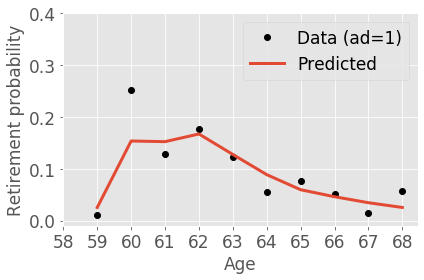

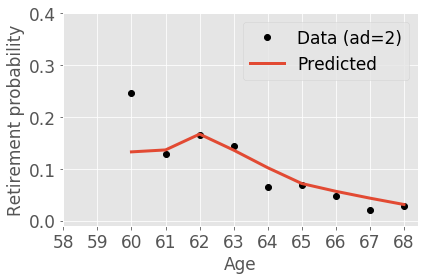

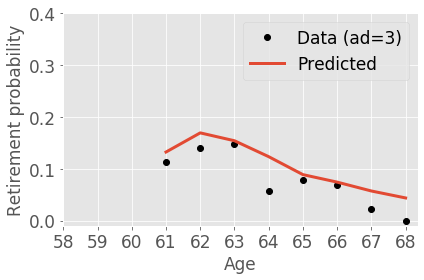

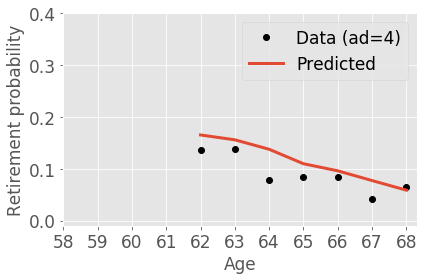

In [212]:
for ad in range(-4,4+1):
    figs.MyPlot(model_fit_ad(0,ad),linewidth=3,ylim=[-0.01,0.4]).savefig('figs/ModelFit/CoupleWomenAD_'+str(ad)+'.png')

Men

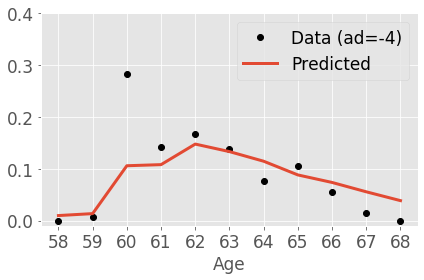

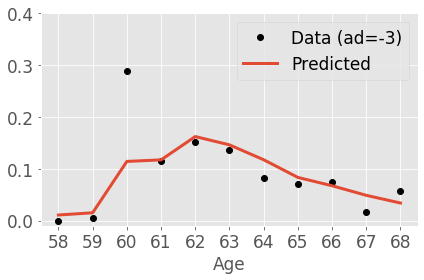

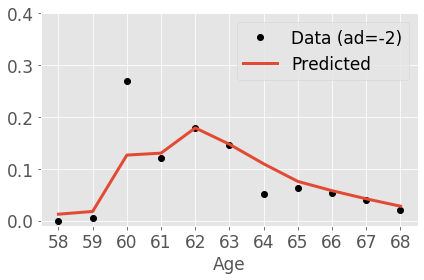

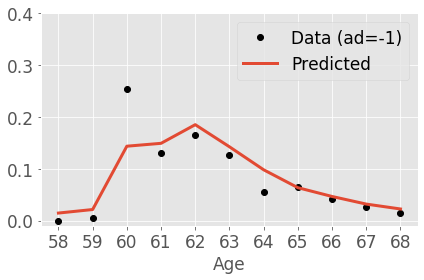

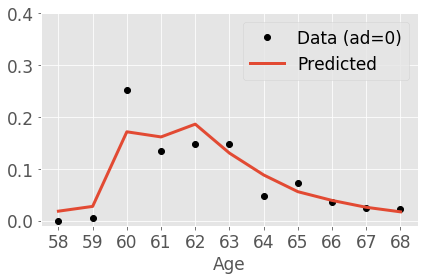

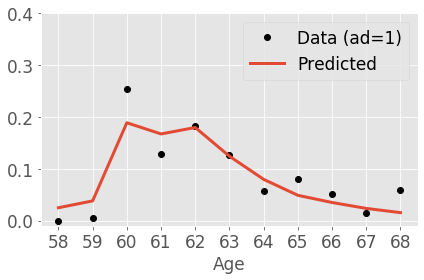

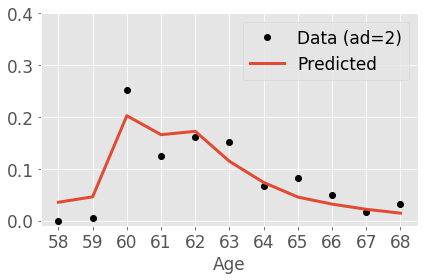

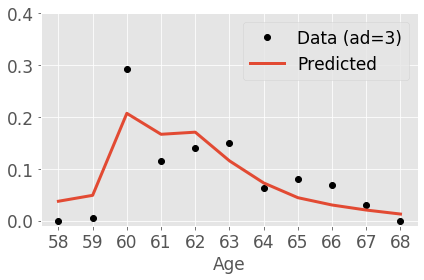

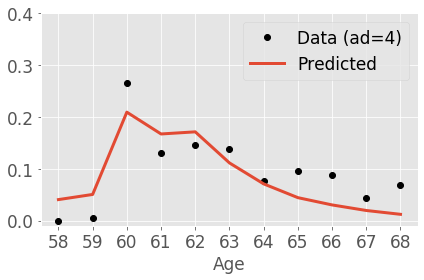

In [213]:
for ad in range(-4,4+1):
    figs.MyPlot(model_fit_ad(1,ad),linewidth=3,ylim=[-0.01,0.4]).savefig('figs/ModelFit/CoupleMenAD_'+str(ad)+'.png')

### Sensitivity to first step calibrated parameters

In [ ]:
smd.recompute=True
smd.sensitivity(theta,weight,fixed_par)
figs.sens_fig_tab(smd.sens2[:,:5],smd.sens2e[:,:5],theta,est_par_tex,fixed_par_tex[:5]).savefig('figs/Sens/CouplePref.png')
figs.sens_fig_tab(smd.sens2[:,5:],smd.sens2e[:,5:],theta,est_par_tex,fixed_par_tex[5:]).savefig('figs/Sens/CoupleCali.png')